### UID (Uniformity of Information Distribution) factor

lagacy code, needs refactor before running

In [1]:
import pandas as pd
import warnings
warnings.filterwarnings('ignore') # for clearness of the output

# S&P 500 companies
tickers = pd.read_csv('tickers2trade.csv')['Symbol'].tolist()
len(tickers)

504

In [2]:
import os

def extract_data(column_name, tickers):
    '''
    Extract data using the given tickers and column name, from intraday data files.
    '''
    directories = ['data/2022', 'data/2023', 'data/2024']

    output_data_dict = {}
    unavailable_tickers = []

    for ticker in tickers: 
        curr_data = pd.DataFrame()
        available = True
        for directory in directories:
            # Get the file path
            file_path = os.path.join(directory, f'{ticker}.csv')
            # Read the data
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                unavailable_tickers.append(ticker)
                available = False
                break  # if no current ticker in any years, ignore this ticker
            data = pd.read_csv(file_path, index_col='DateTime', parse_dates=True)
            # Filter data from 9:30 to 4 pm for all days
            data = data.between_time('09:30', '16:00')
        
            # Append the data to the curr_data DataFrame
            if curr_data.empty:
                curr_data = data[column_name]
            else:
                curr_data = pd.concat([curr_data, data[column_name]])
        
        if not available:
            continue
        curr_data = curr_data[~curr_data.index.duplicated(keep='first')]
        output_data_dict[ticker] = curr_data

    # Combine all data into a single DataFrame
    ouput_data = pd.concat(output_data_dict, axis=1)

    return ouput_data

In [3]:
# loading prepared data
close_data = pd.read_csv('close_data.csv', index_col='DateTime', parse_dates=True)
# filling missing values using previous row values
close_data_prepared = close_data.ffill()

In [4]:
def get_uid_factor(close_data: pd.DataFrame, freq='M') -> pd.DataFrame:
  '''
  This function returns the UID factor for given stocks.

  Parameters:
    close_data: DataFrame with stocks intraday close prices, indexed by datetime.
    freq: Frequency of the resampling. Default is 'M' for monthly.
  Returns:
    DataFrame with weekly UID factor for given stocks, indexed by datetime.
  '''

  # calculating daily volatility using intraday data
  vol_daily = close_data.groupby(pd.Grouper(freq='D')).apply(lambda x: x.pct_change().std())

  # calculating rolling standard deviation of previous 20 days
  rolling_std_on_vols = vol_daily.rolling(window=20, min_periods=5).std()
  # resample the data to weekly frequency and take the last value of each week
  period_std_on_vols = rolling_std_on_vols.groupby(pd.Grouper(freq=freq)).last()

  # same logic for mean values on daily vol
  rolling_mean_on_vols = vol_daily.rolling(window=20, min_periods=5).mean()
  period_mean_on_vols = rolling_mean_on_vols.groupby(pd.Grouper(freq=freq)).last()

  return period_std_on_vols / period_mean_on_vols

In [14]:
uid_factor_data = get_uid_factor(close_data_prepared)

### Analysis

the factor's ic is -0.04009283957085058
the factor's ir is -0.5419993352307663




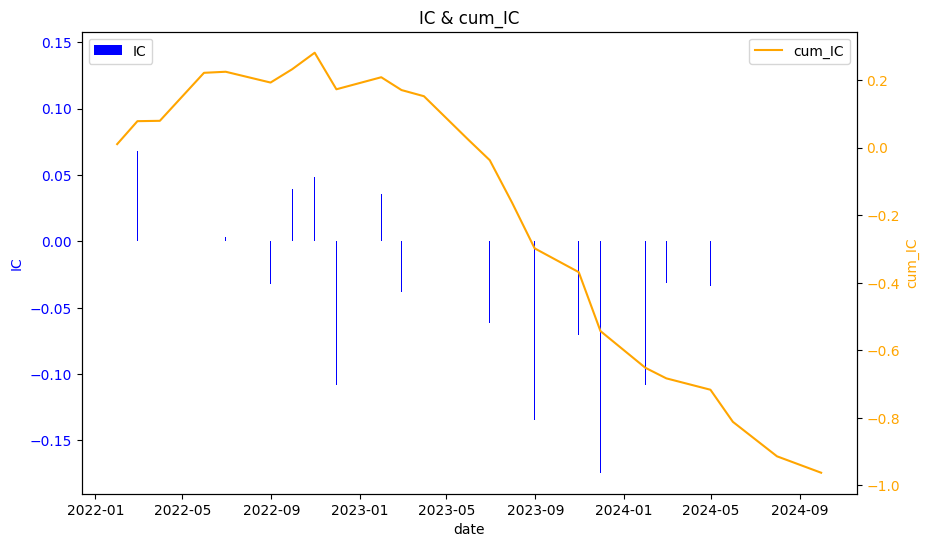

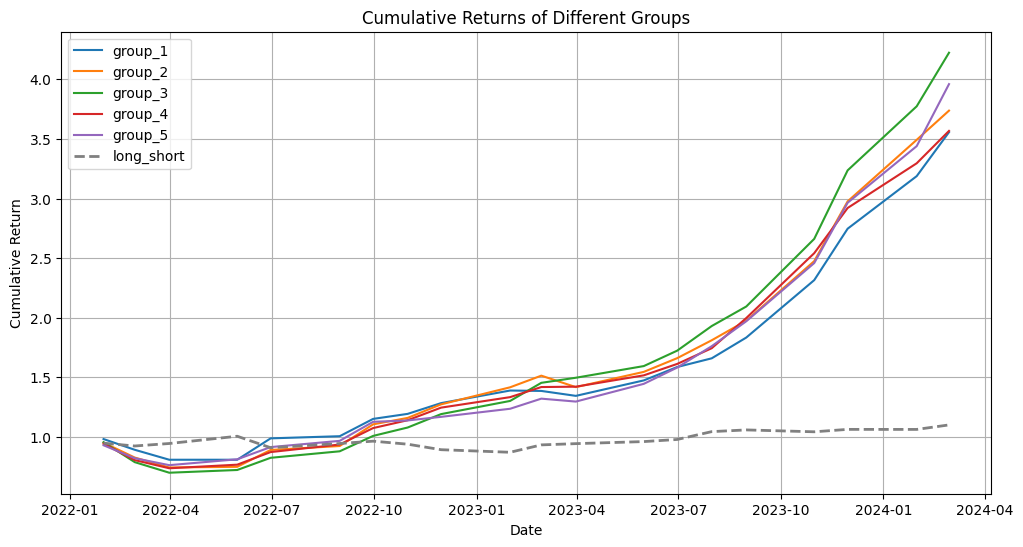


=== Backtesting statistical metrics ===
transaction_cost: 0.00%(single side)
Annualized return:
group_1       17.5438
group_2       18.3924
group_3       20.0524
group_4       17.5193
group_5       18.9793
long_short     1.4355
dtype: float64

Annualized volatility:
group_1       1.5307
group_2       1.6384
group_3       1.6230
group_4       1.4562
group_5       1.5066
long_short    0.6775
dtype: float64

Sharpe ratio:
group_1       11.4613
group_2       11.2258
group_3       12.3551
group_4       12.0308
group_5       12.5974
long_short     2.1188
dtype: float64

max drawback:
group_1      -0.1767
group_2      -0.2189
group_3      -0.2679
group_4      -0.2181
group_5      -0.1794
long_short   -0.1337
dtype: float64


In [17]:
from util import *

all_data = pd.read_pickle('all_data.pkl')
create_factor_graphs_v2(all_data, uid_factor_data, 'uid')

In [24]:
import numpy as np
import alphalens as al # pip install alphalens-reloaded

def create_factor_graphs(graph_data, price_data):
  '''
  This function creates factor graphs using Alphalens library.
  factor_data and price_data should be aligned and have the same index/same frequency.
  '''

  # helper function for data preparation
  def generate_experiment_data(data):
    experiment_data = pd.DataFrame({
      'instrument': list(data.columns) * len(data.index),
      'date': np.repeat(data.index, len(data.columns)),
      'factor': data.values.flatten()
    })

    experiment_data.set_index(['date', 'instrument'], inplace=True)

    return experiment_data
  
  experiment_data = generate_experiment_data(graph_data)

  # price should be shifted by 1 day to align with factor data
  # (factor data -> make decision -> next day price)
  price_data_shifted = price_data.shift(-1)

  # generating garphs
  graph_data = al.utils.get_clean_factor_and_forward_returns(experiment_data, price_data_shifted, quantiles=20, max_loss=0.4)
  al.tears.create_full_tear_sheet(graph_data)

Dropped 27.9% entries from factor data: 27.9% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 40.0%, not exceeded: OK!
Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,0.050579,0.200901,0.110661,0.030801,650,5.036417
2,0.085867,0.214149,0.129469,0.031466,650,5.036417
3,0.099982,0.223698,0.139161,0.031859,648,5.020921
4,0.105146,0.234187,0.147419,0.032179,649,5.028669
5,0.112461,0.240146,0.154618,0.032504,642,4.974430
6,0.116751,0.246683,0.161497,0.032214,633,4.904695
7,0.121234,0.253520,0.168146,0.032489,649,5.028669
8,0.126142,0.258086,0.175754,0.032315,650,5.036417
9,0.132808,0.264096,0.183127,0.032164,640,4.958934


Returns Analysis


,1D,5D,10D
Ann. alpha,-0.007,-0.111,-0.026
beta,0.015,-0.014,0.010
Mean Period Wise Return Top Quantile (bps),43.770,2.848,0.454
Mean Period Wise Return Bottom Quantile (bps),-26.846,-4.603,-8.891
Mean Period Wise Spread (bps),70.616,7.622,9.680


<Figure size 640x480 with 0 Axes>

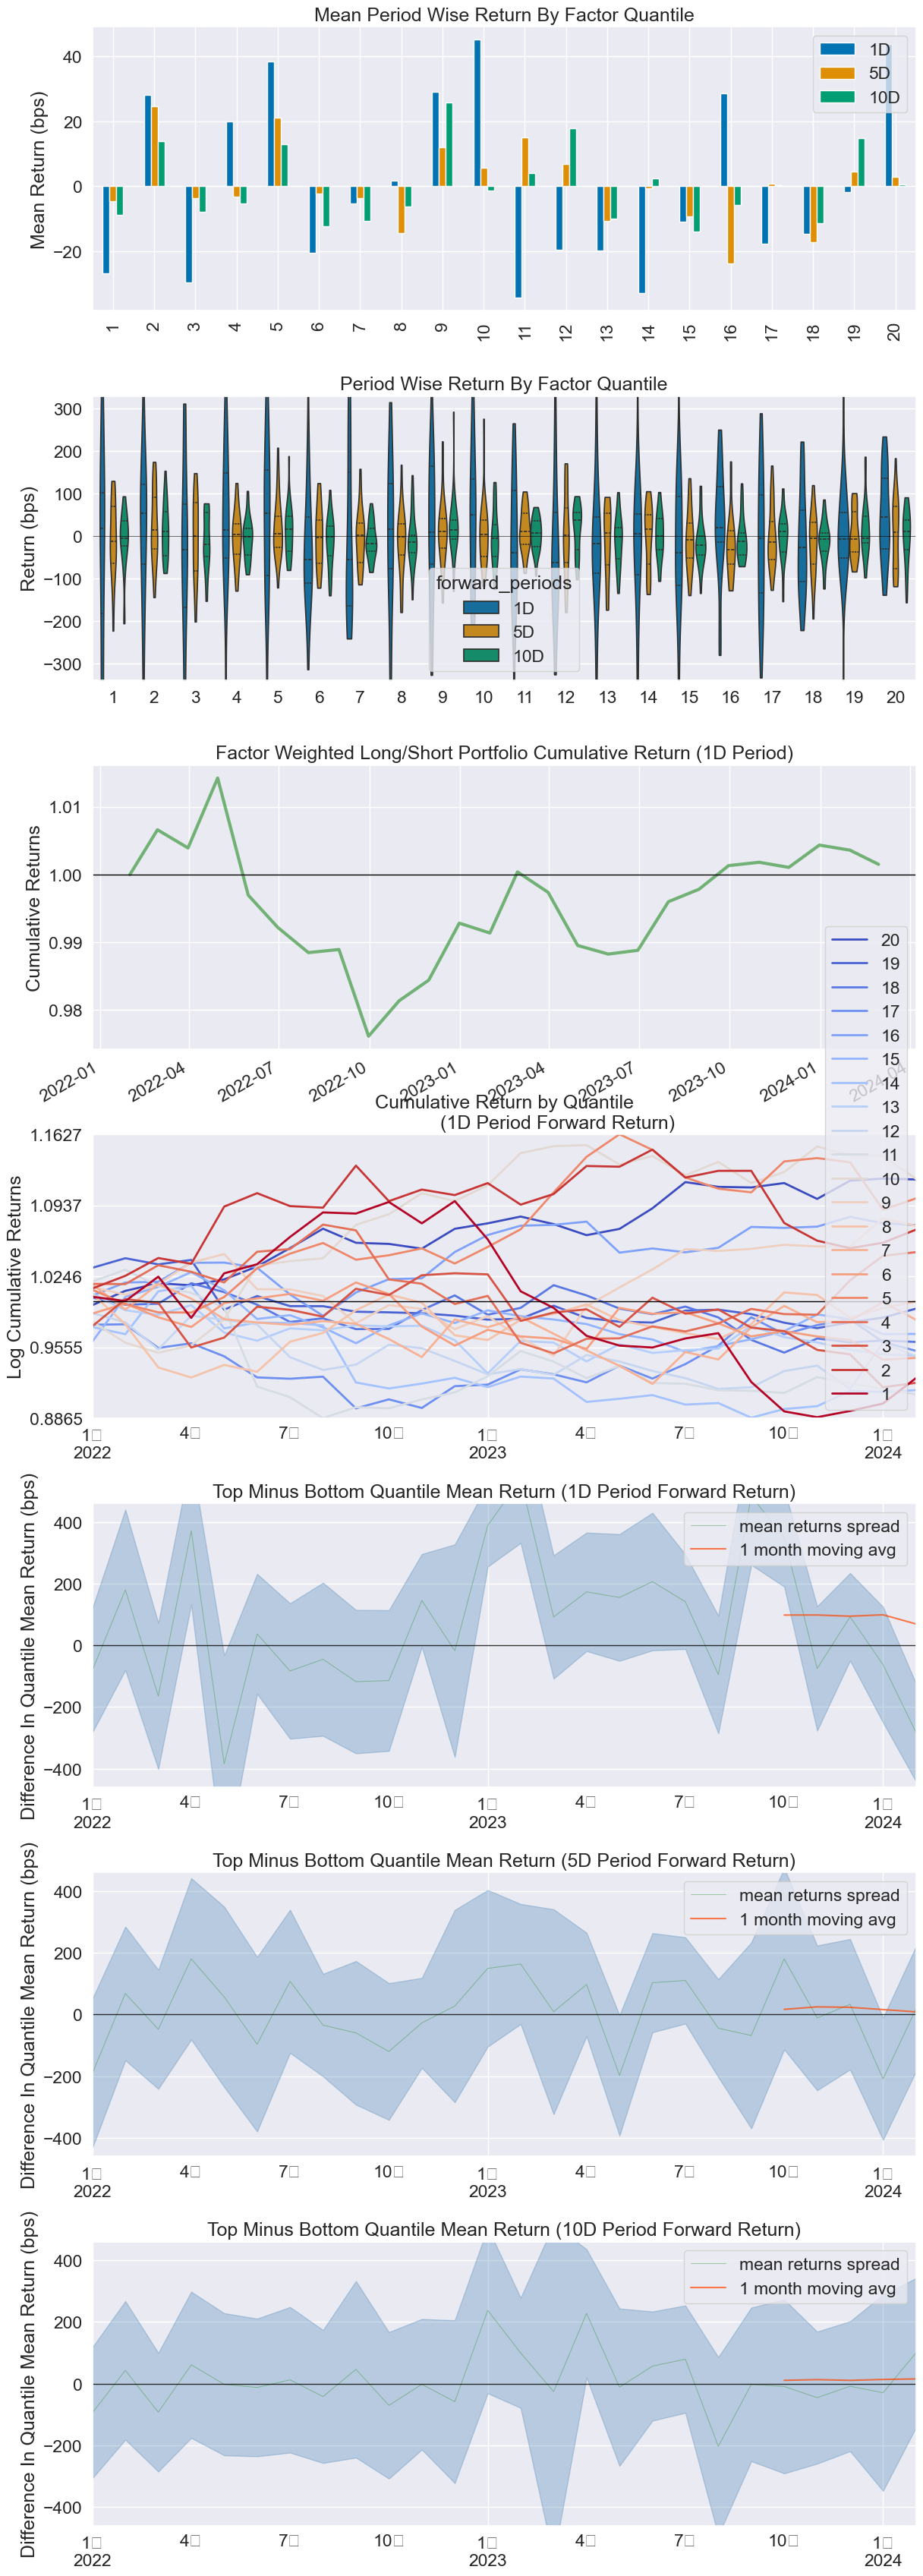

Information Analysis


,1D,5D,10D
IC Mean,0.001,0.004,0.013
IC Std.,0.072,0.092,0.059
Risk-Adjusted IC,0.016,0.041,0.230
t-stat(IC),0.079,0.208,1.174
p-value(IC),0.938,0.837,0.251
IC Skew,-0.470,-0.085,0.258
IC Kurtosis,-0.244,-1.094,0.575


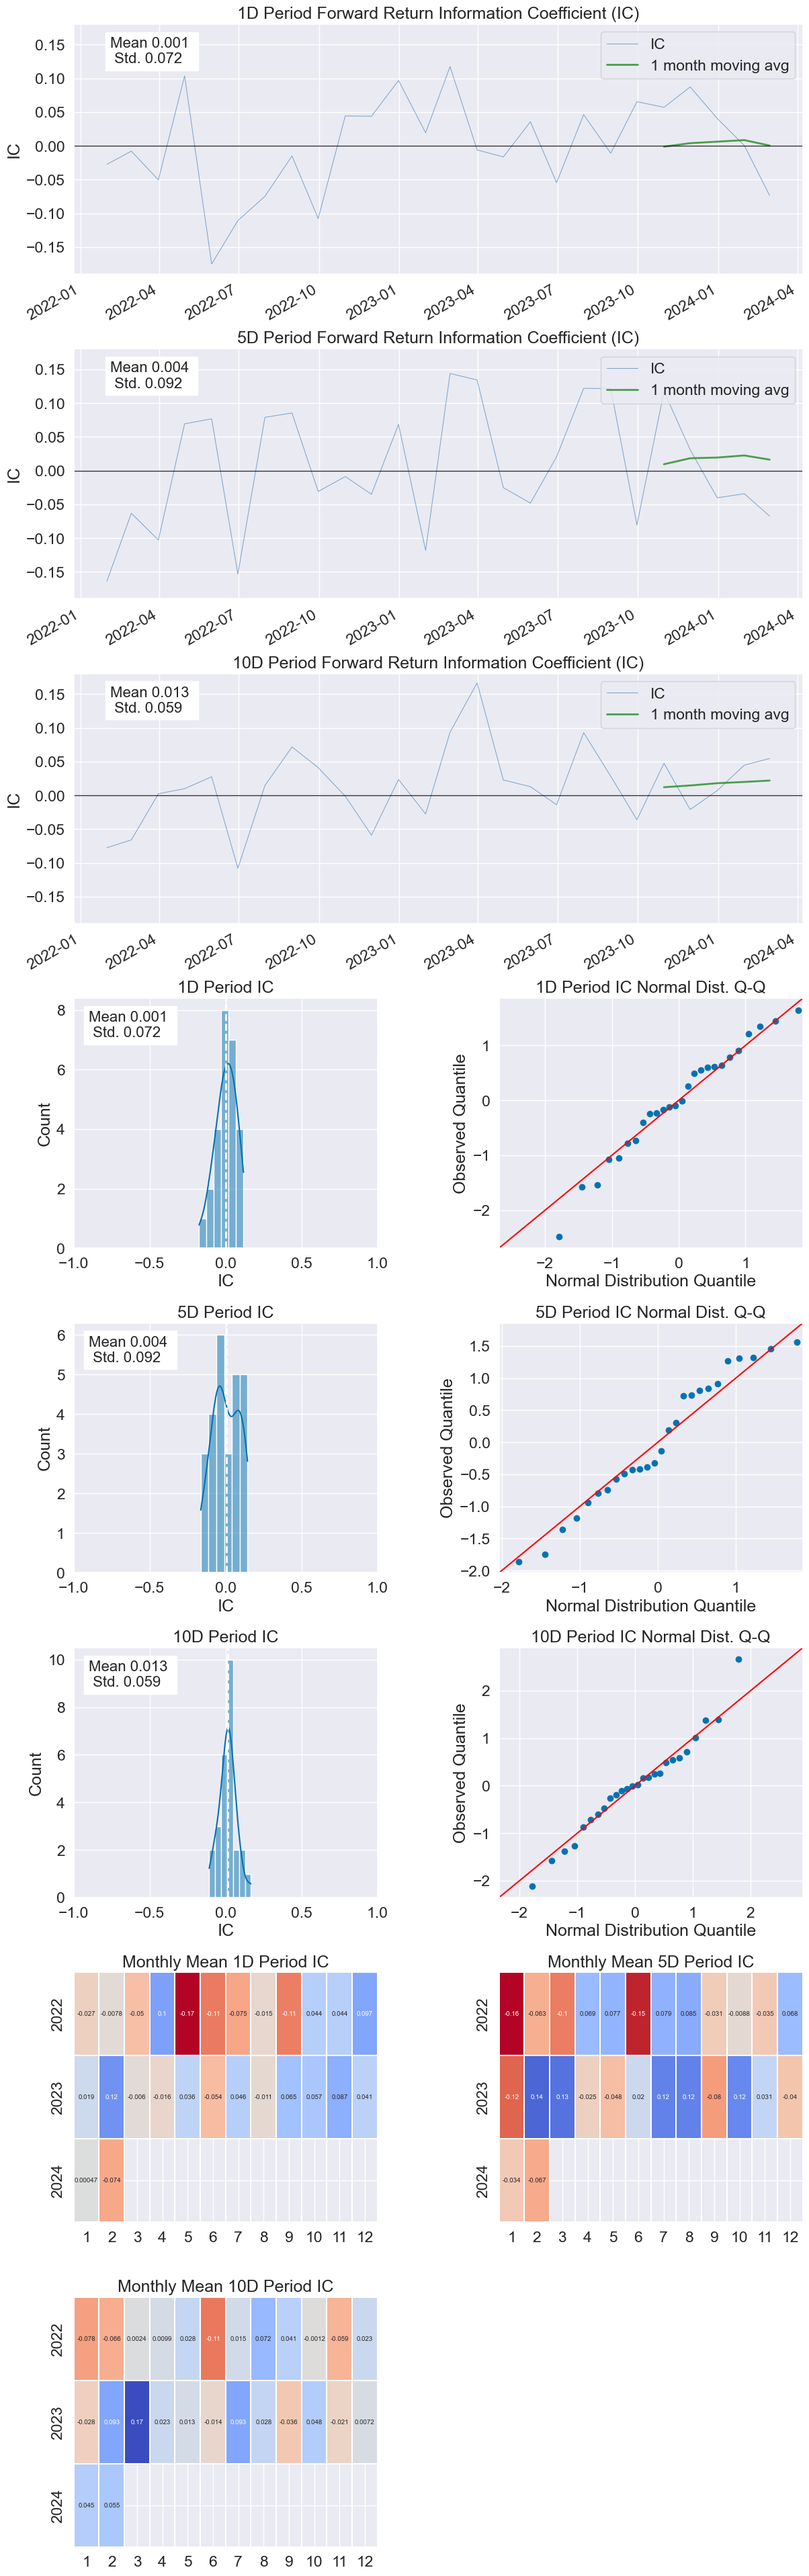

Turnover Analysis


,1D,5D,10D
Quantile 1 Mean Turnover,0.914,0.943,0.925
Quantile 2 Mean Turnover,0.939,0.924,0.940
Quantile 3 Mean Turnover,0.963,0.956,0.952
Quantile 4 Mean Turnover,0.950,0.970,0.965
Quantile 5 Mean Turnover,0.946,0.948,0.952
Quantile 6 Mean Turnover,0.939,0.968,0.964
Quantile 7 Mean Turnover,0.949,0.954,0.950
Quantile 8 Mean Turnover,0.938,0.950,0.965
Quantile 9 Mean Turnover,0.953,0.954,0.958
Quantile 10 Mean Turnover,0.962,0.939,0.955


,1D,5D,10D
Mean Factor Rank Autocorrelation,0.014,0.044,0.01


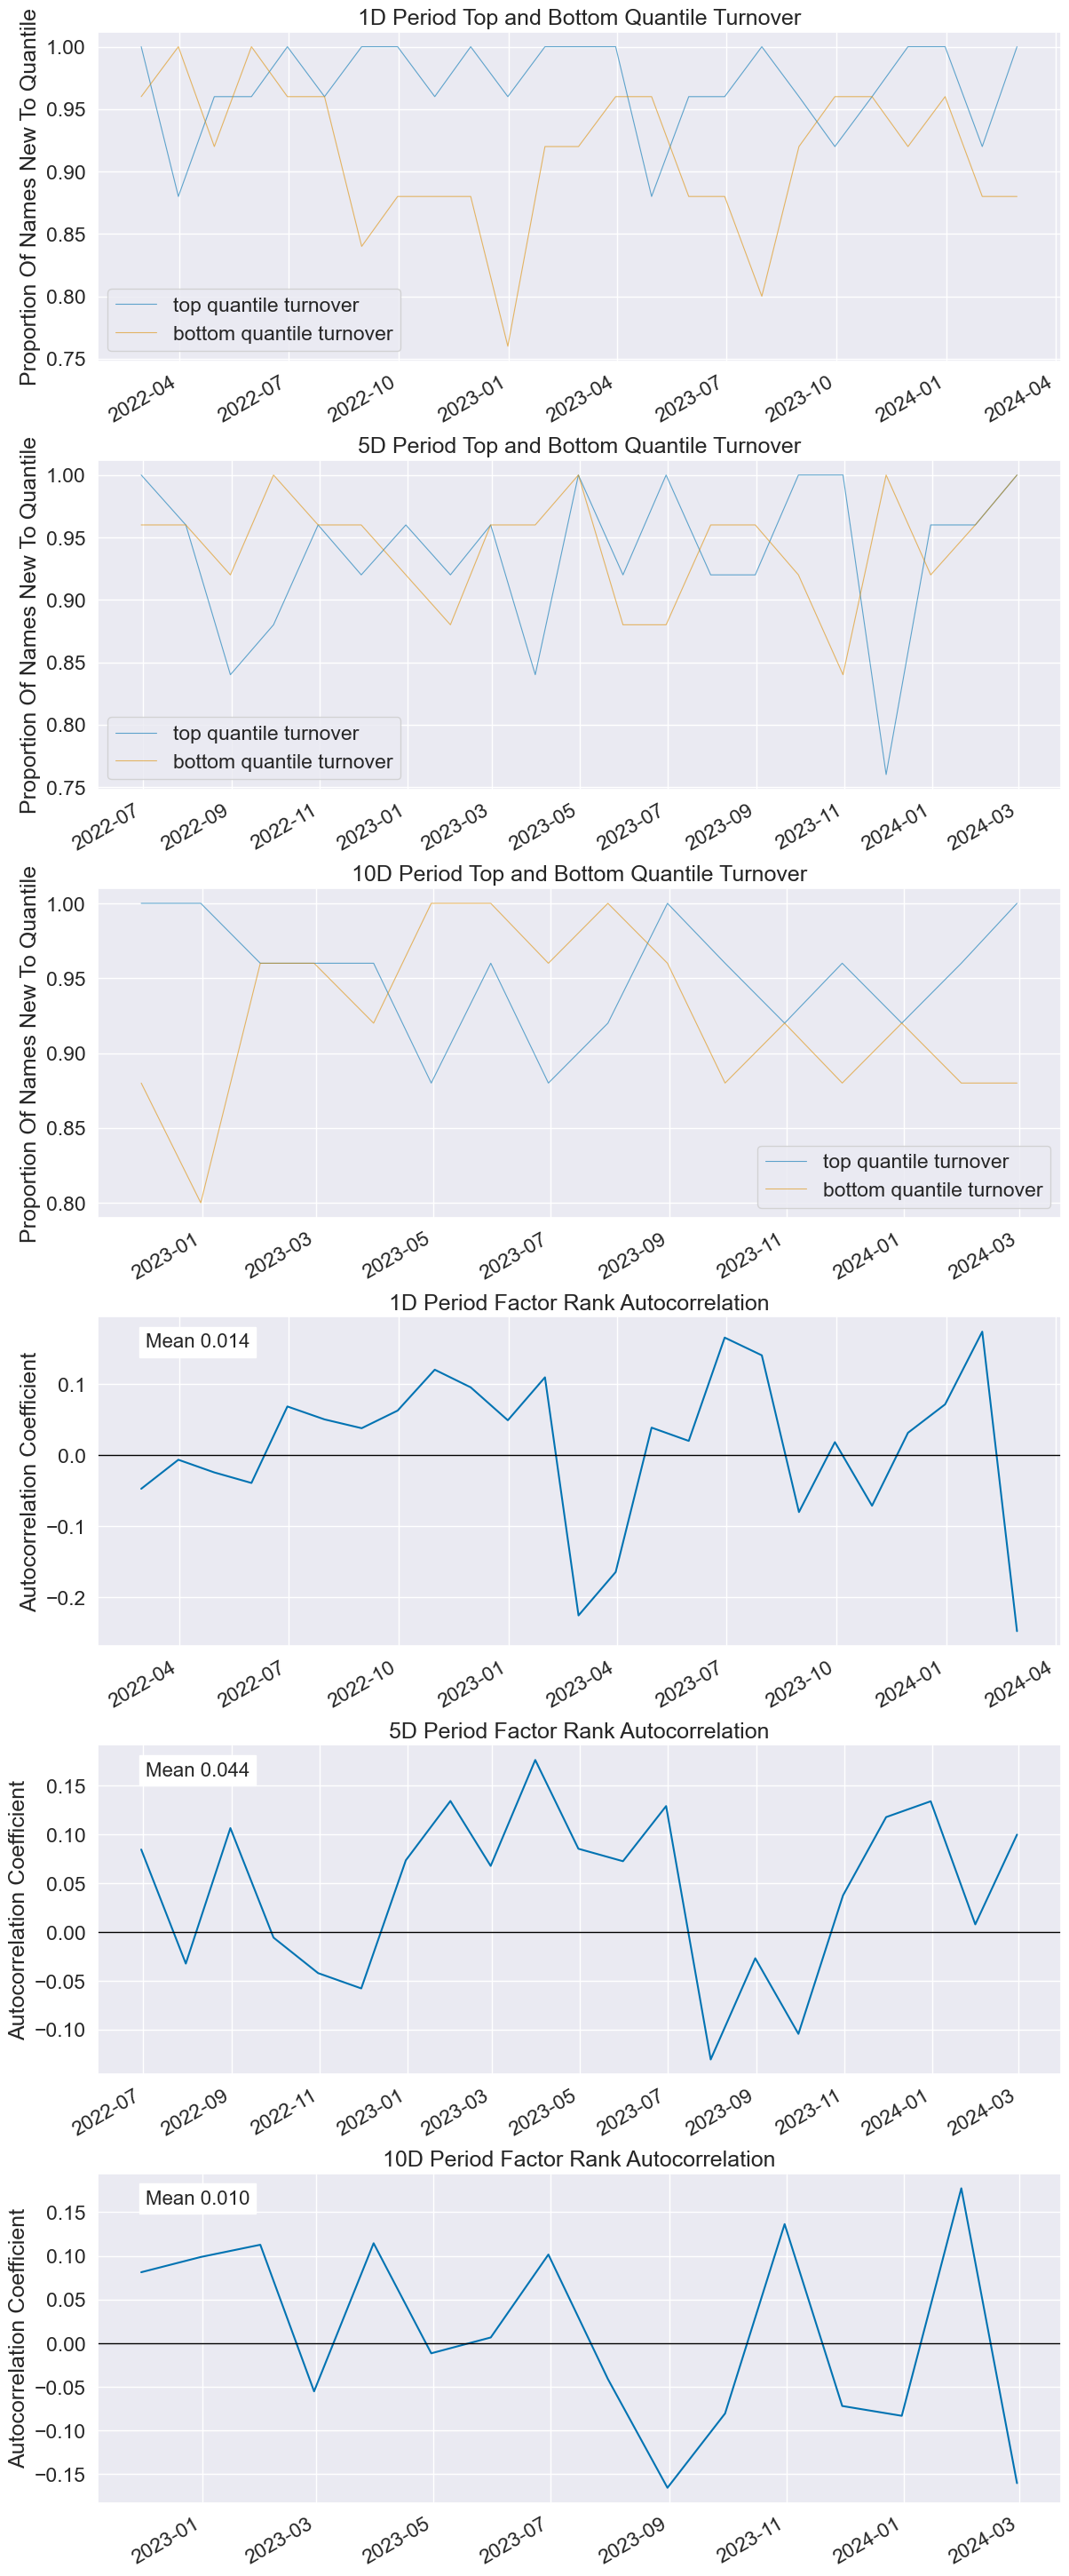

In [ ]:
open_data_monthly = pd.read_csv('open_data_monthly.csv', index_col='DateTime', parse_dates=True)
create_factor_graphs(uid_factor_data_monthly, open_data_monthly)